In [1]:
import sys
sys.path.append('/usr/local/lib/ViennaRNA/python3.6/site-packages/') 

from models.RNA_landscapes import *
from utils.landscape_utils import *
from utils.sequence_utils import *
import RNA
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from matplotlib import rc
rc("text", usetex=False)
rc("font", family = "serif",size=20)
rc("figure",figsize=(9,6))
rc("figure",facecolor="white")
%config InlineBackend.figure_format = 'retina'

In [4]:
RNAA="CUGA"
seq_len=50 #fix this for now, only dealing with substitutions
num_sequences=1000
sequences=generate_random_sequences(seq_len,num_sequences,alphabet=RNAA)
# sequences

In [5]:
count = sum(1 for a, b in zip(sequences[0], sequences[1]) if a != b)

In [6]:
def seq_sim(seq0,seq1):
    return sum(1 for a, b in zip(seq0, seq1) if a != b)
sim = np.zeros((num_sequences,num_sequences))
for i in range(num_sequences):
    for j in range(i,num_sequences):
        sim[i,j] = seq_sim(sequences[i],sequences[j])

In [7]:
a = sim+sim.T
a[np.diag_indices_from(a)] = np.inf
idx = np.unravel_index(np.argmin(a),a.shape)
idx

(156, 791)

In [8]:
a[idx]

RNA.fold(sequences[500])

['........................(((((..((.......))..))))).', -3.5]

In [9]:
simulator_1=RNA_landscape(sequences[0],norm_value=-13.89) 


In [10]:
simulator_1.get_fitness(sequences[5]),simulator_1.get_fitness("G"*int(seq_len/2)+"C"*int(seq_len/2))
fitness = np.zeros(num_sequences)
for i in range(num_sequences):
    fitness[i] = simulator_1.get_fitness(sequences[i])

In [11]:
A = np.arange(5)
B = np.arange(5)
diff = A[:, np.newaxis] - B[np.newaxis, :]
diff

array([[ 0, -1, -2, -3, -4],
       [ 1,  0, -1, -2, -3],
       [ 2,  1,  0, -1, -2],
       [ 3,  2,  1,  0, -1],
       [ 4,  3,  2,  1,  0]])

In [12]:
fitness[:,None]-fitness[None,:]

array([[ 0.        ,  0.10799136,  0.29517634, ..., -0.24478042,
         0.21598272,  0.01439883],
       [-0.10799136,  0.        ,  0.18718498, ..., -0.35277179,
         0.10799136, -0.09359253],
       [-0.29517634, -0.18718498,  0.        , ..., -0.53995677,
        -0.07919362, -0.28077751],
       ..., 
       [ 0.24478042,  0.35277179,  0.53995677, ...,  0.        ,
         0.46076315,  0.25917926],
       [-0.21598272, -0.10799136,  0.07919362, ..., -0.46076315,
         0.        , -0.20158389],
       [-0.01439883,  0.09359253,  0.28077751, ..., -0.25917926,
         0.20158389,  0.        ]])

In [13]:
fitness_diff = np.abs(fitness[:,None]-fitness[None,:])

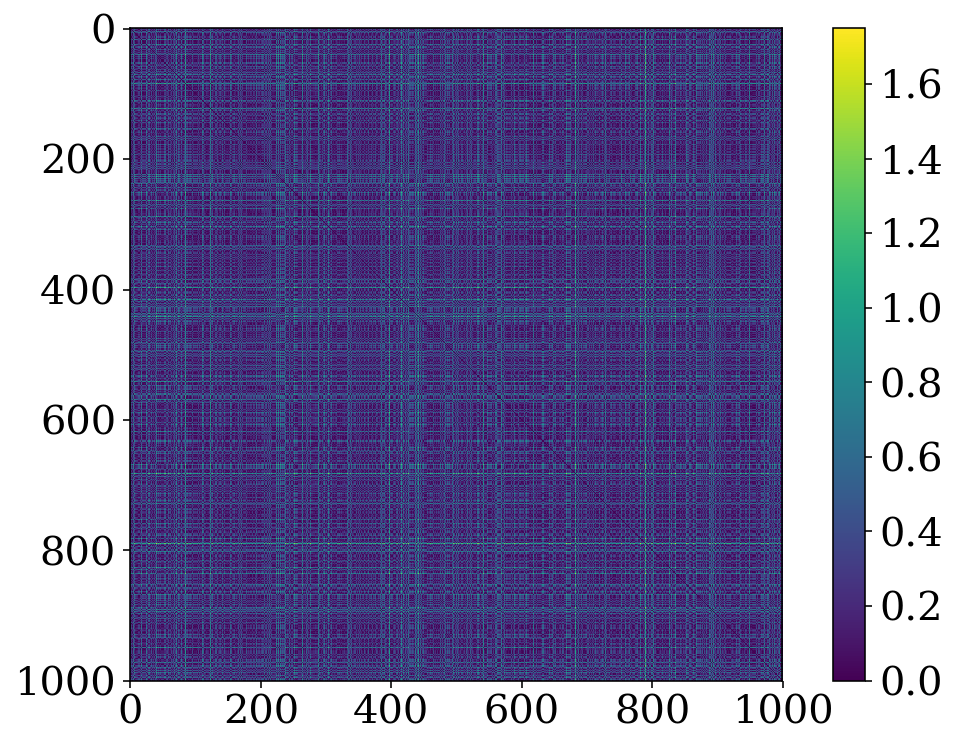

In [14]:
plt.imshow(np.abs(fitness_diff))
plt.colorbar()
plt.show()

In [15]:
fit_idx = np.unravel_index(np.argmax(np.abs(fitness_diff)),fitness_diff.shape)
fitness_diff[fit_idx]

1.7494599882692978

In [16]:
fit_idx

(378, 672)

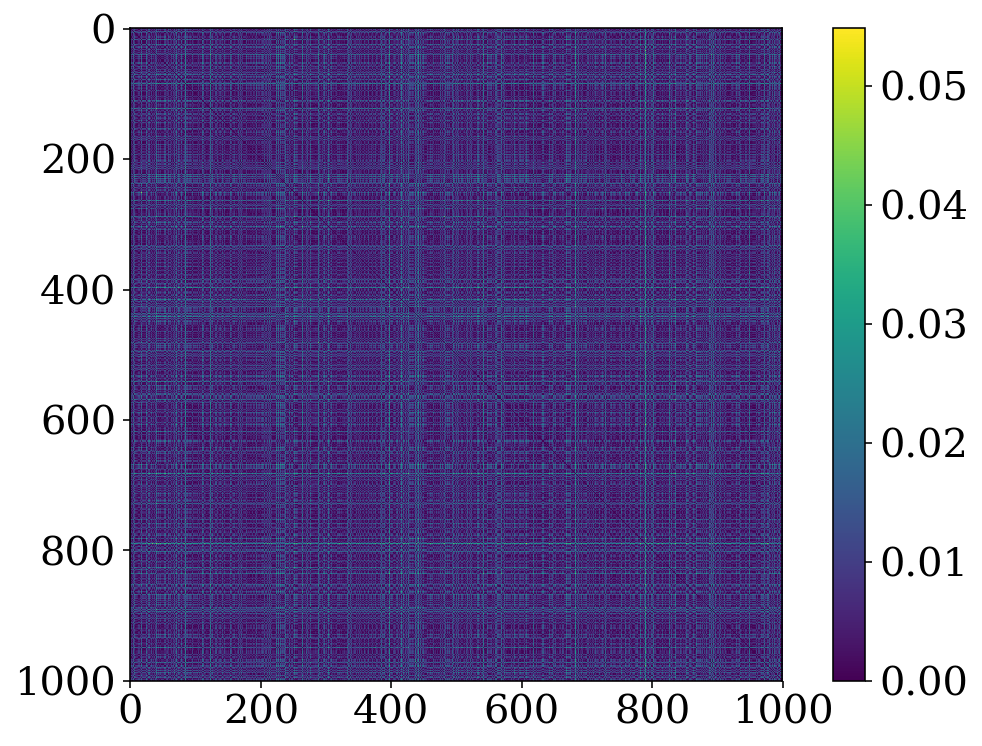

In [17]:
epi_size = fitness_diff/a**2
plt.imshow(fitness_diff/a)
plt.colorbar()
plt.show()

In [18]:
epi_idx = np.unravel_index(np.argmax(epi_size),epi_size.shape)
epi_size[epi_idx]

0.001932548551316182

In [19]:
print(sequences[epi_idx[0]])
sequences[epi_idx[1]]

GUACCCGCAUACCGAUGCCCUGACGGUUGCGAUACUGCGGGCCUCAUAAU


'AAAGACUCCUUCCUGUGCGCUCUUAUUUGUAAUAGCUCCUGCCUAAUAAU'

In [18]:
seq_sim(sequences[epi_idx[0]],sequences[epi_idx[1]])

26

Starting with a sequence and making mutations to get the largest difference in folding energy

In [169]:
base_seq = 'UCCCUCCGAUACGUCUAUUCCCUGCACUCCUUCUAGUAUGCAGCCUGACU'
good_mutations = ['U0A', 'C2A', 'C21A', 'U22A', 'C29G']

In [197]:
replace_alpha = {'C':['U','G','A'],
                 'U':['G','A','C'],
                 'G':['A','C','U'],
                 'A':['C','U','G']}
def gen_n_mutations(orig, n=10):
    seq = list(orig)
    mutation_list = []
    for i in np.sort(np.random.choice(np.arange(len(orig)),replace=False,size=n)):
        seq[i]  = np.random.choice(replace_alpha[seq[i]])
        mutation_list.append(''.join([orig[i],str(i),seq[i]]))
    
    return ''.join(x for x in seq),mutation_list
mut_seq,mut_list = gen_n_mutations(base_seq,n=5)
# new_seq = print(base_seq)
mut_list

['C6U', 'C14G', 'U17C', 'U22G', 'G35C']

In [198]:
RNA.fold(mut_seq)

['............((((.......)))).......................', -2.799999952316284]

In [199]:
RNA.fold(base_seq)

['............(((......(((((..(......)..)))))...))).', -6.800000190734863]

## Calc first order epistatic term

- Generate all first order mutants
- Construct epistasis matrix
- repeat for higher order

In [139]:
def do_point_mutation(orig_seq, mutation):
    """
    do -> defined mutation
    gen -> random mutation
    """
    if mutation == '' or mutation is None:
        #don't actually perform a mutation
        #stay as wt
        print('here')
        return orig_seq
    idx = np.int(mutation[1:-1])
    return orig_seq[:idx]+mutation[-1]+orig_seq[idx+1:]
def do_n_mutation(orig_seq, mut_list, which=None):
    """
    inputs
    ------
    mut_list : list of strings
                mutations of form 'baselocationbase' eg U30C
    which : iterable, integer, None, 'all','first,'last'
                indices of mut_list to perform
                None -> all
                'all' -> all
                'first' -> first
                'last' -> last
    """
    if which is None or which=='all':
        which = np.arange(len(mut_list))
    elif which=='first':
        which = [0]
    elif which =='last':
        which = [-1]
    else:
        which = np.atleast_1d(which)
    seq = ''+orig_seq
    for m in which:
        seq = do_point_mutation(seq,mut_list[m])
    return seq



letters_2_num = {'C':0,'U':1,'G':2,'A':3}
def str2num(seq):
    return [letters_2_num[character] for character in seq]

In [140]:
for i,m in enumerate(mut_list):
    do_point_mutation(base_seq,m)

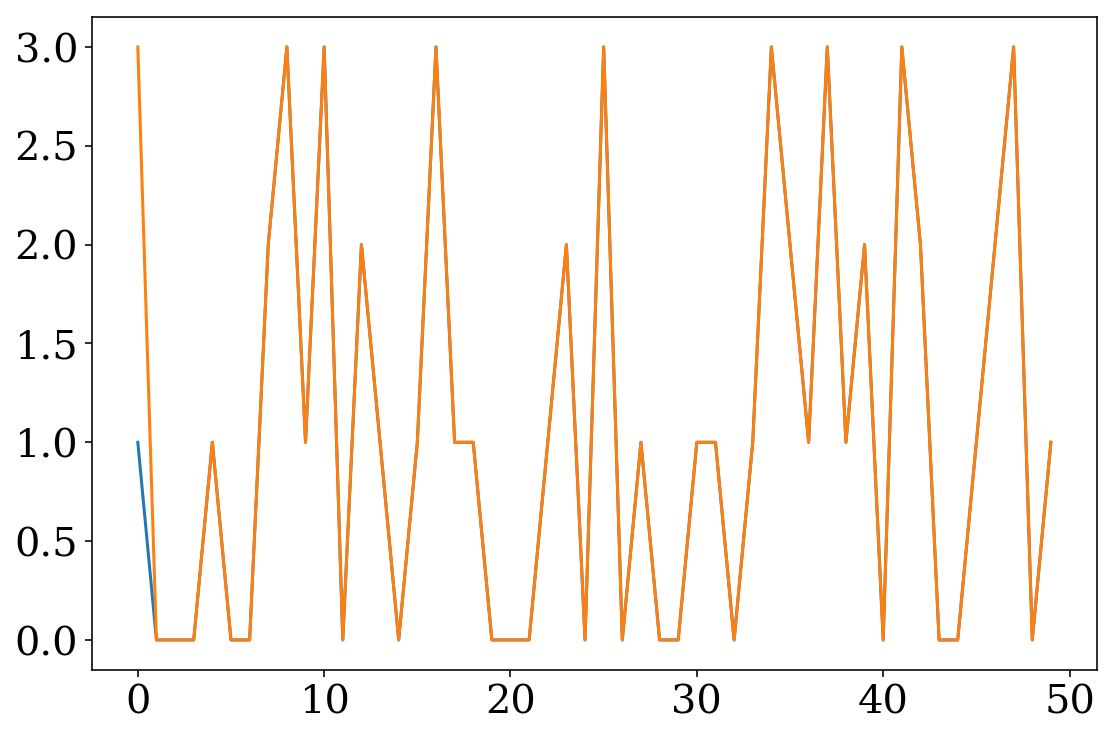

In [141]:
plt.plot(str2num(base_seq))
plt.plot(str2num(do_n_mutation(base_seq,mut_list,'first')))

In [200]:
N_mutation = len(mut_list)
first_order = np.zeros(N_mutation)
for i,m in enumerate(mut_list):
    first_order[i] = RNA.fold(do_point_mutation(base_seq,m))[-1]

In [201]:
base_fitness = RNA.fold(base_seq)[1]
first_order -= base_fitness


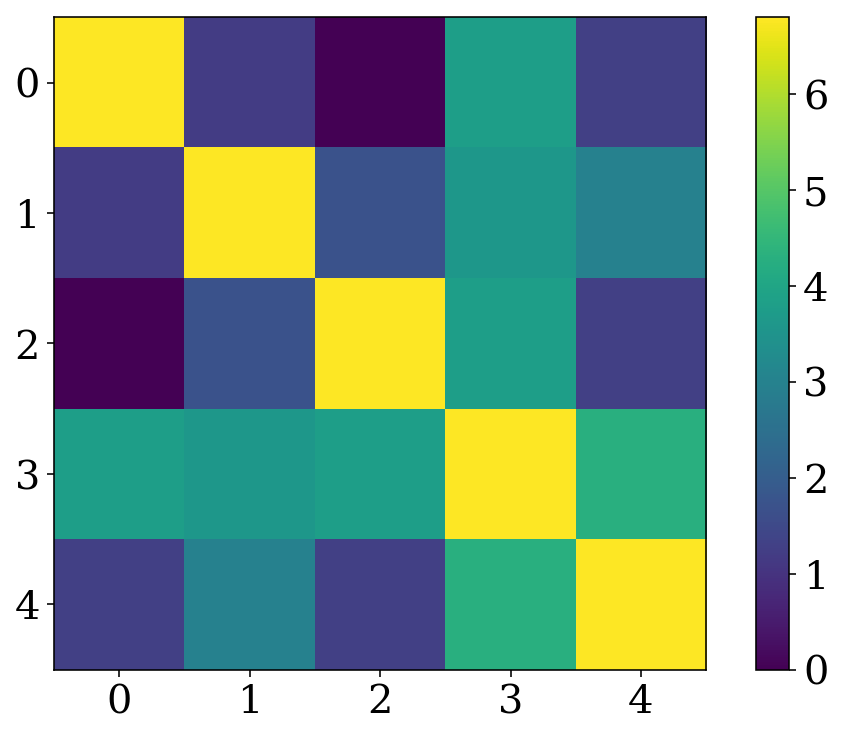

In [204]:
second_order_fitness  = np.zeros([N_mutation,N_mutation])
second_order_linear = first_order[:,None]@first_order[None,:]


for i in range(len(mut_list)):
    for j in range(i+1,len(mut_list)):
        seq = do_n_mutation(base_seq,mut_list,[i,j])
        second_order_fitness[i,j] = RNA.fold(seq)[1]
second_order_fitness+= second_order_fitness.T
second_order_fitness-=base_fitness
second_order_linear+= second_order_linear.T-base_fitness
plt.imshow(second_order_fitness)
plt.colorbar()
plt.show()

In [228]:
fitnesses = np.zeros([N_mutation,N_mutation])

ref_fitness = RNA.fold(base_seq)[1]

for i in range(N_mutation):
#     seq = do_n_mutation(base_seq,mut_list,[i])
#     fitnesses[0,i] = RNA.fold(seq)[-1]
    for j in range(i,N_mutation):
        seq = do_n_mutation(base_seq,mut_list,[i,j])
        fitnesses[i,j] = RNA.fold(seq)[-1]    

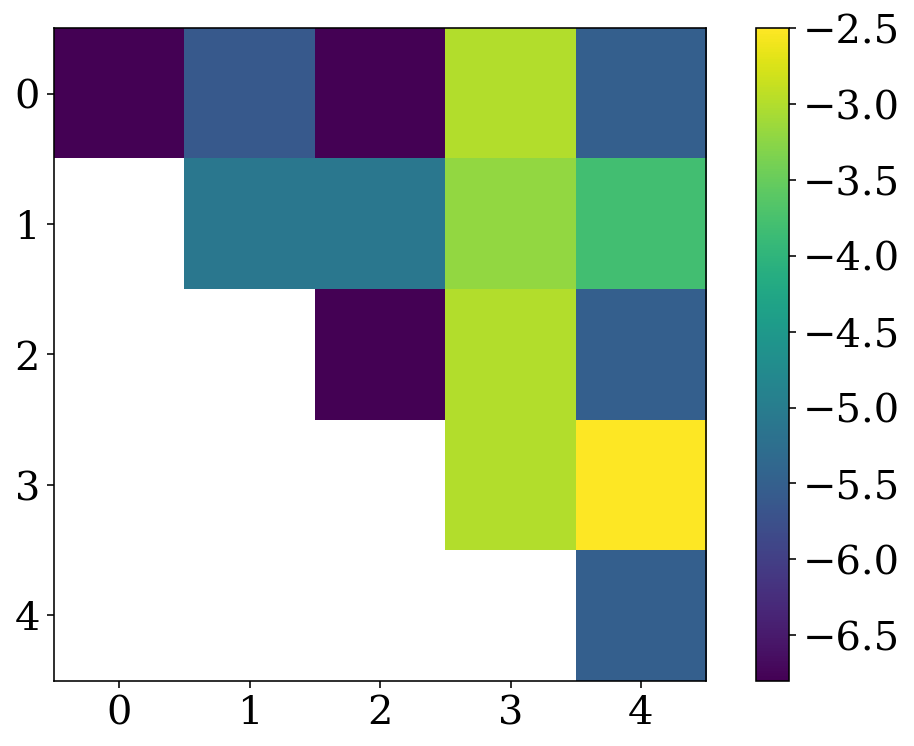

In [229]:
def imshow_masked(arr,cbar=True,offset = -1):
    """
    imshow with the lower triangle masked
    """
    n = arr.shape[0]
    idx = np.tril_indices(n,k=offset)
    mask_arr =np.ones([n,n])
    mask_arr[idx[0],idx[1]]=0
#     mask_arr[0,0]=1
    a = np.ma.masked_where(mask_arr==0, arr)
    plt.imshow(a)
    if cbar:
        plt.colorbar()
imshow_masked(fitnesses)
plt.show()

In [230]:
#getting the frist order
np.diag(fitnesses)-ref_fitness


#getting the second order

second_order = np.zeros([N_mutation,N_mutation])
# arr = np.diag()
diag = np.diag(fitnesses)
# for bkgd in range(N_mutation):
#     for mut in range(N_mutation):
#         second_order[bkgd,mut] = (fitnesses[bkgd,mut] - diag[bkgd])-(diag[mut]- ref_fitness)

second_order = (fitnesses - diag[:,None]) - (diag[None,:]+ref_fitness)

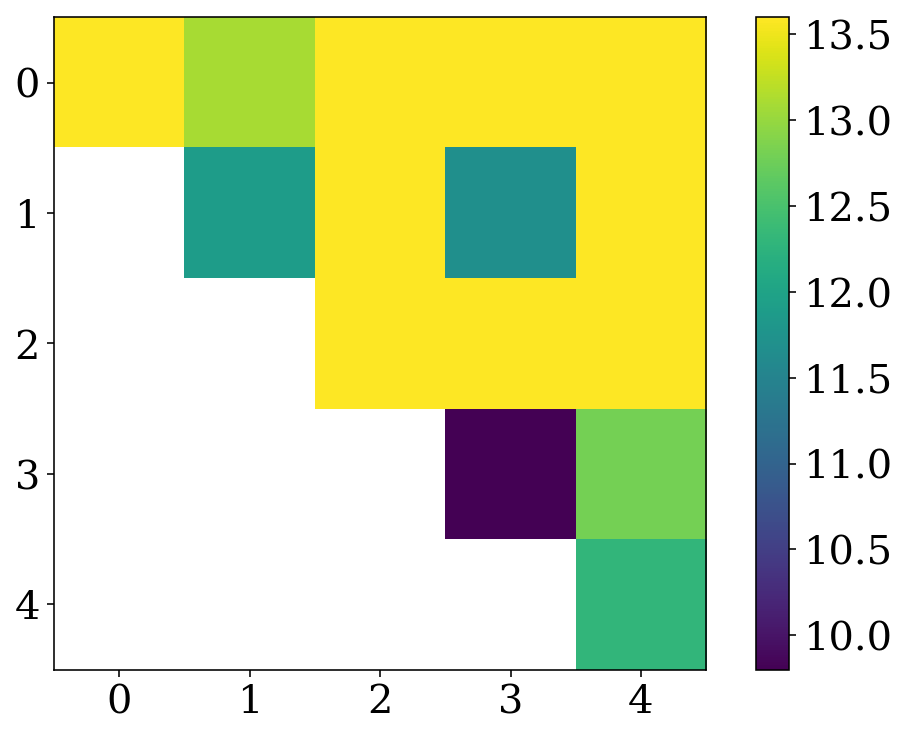

In [231]:
imshow_masked(second_order)


Test case based on poelwijk figure 2

In [209]:
ref = .89
fit = np.array([[.29,1.31],[1.31,.78]])
N = 2
diag = np.diag(fit)
second_order = np.zeros([N,N])
for bkgd in range(N):
    for mut in range(N):
        second_order[bkgd,mut] = (fit[bkgd,mut]-diag[bkgd]) - (diag[mut]-ref)
# imshow_masked(second_order)
print(fit)
second_order

[[ 0.29  1.31]
 [ 1.31  0.78]]


array([[ 0.6 ,  1.13],
       [ 1.13,  0.11]])

In [210]:
(diag[:,None]@diag[None,:])/2

array([[ 0.04205,  0.1131 ],
       [ 0.1131 ,  0.3042 ]])

In [211]:
fit - diag[:,None]-diag[None,:]+ref
#diag[:,None] basically creates a 2d matrix where each row is the background fitness
#diag[None,:] creates the 2D matrix where each column is the first order mutation fitness

array([[ 0.6 ,  1.13],
       [ 1.13,  0.11]])

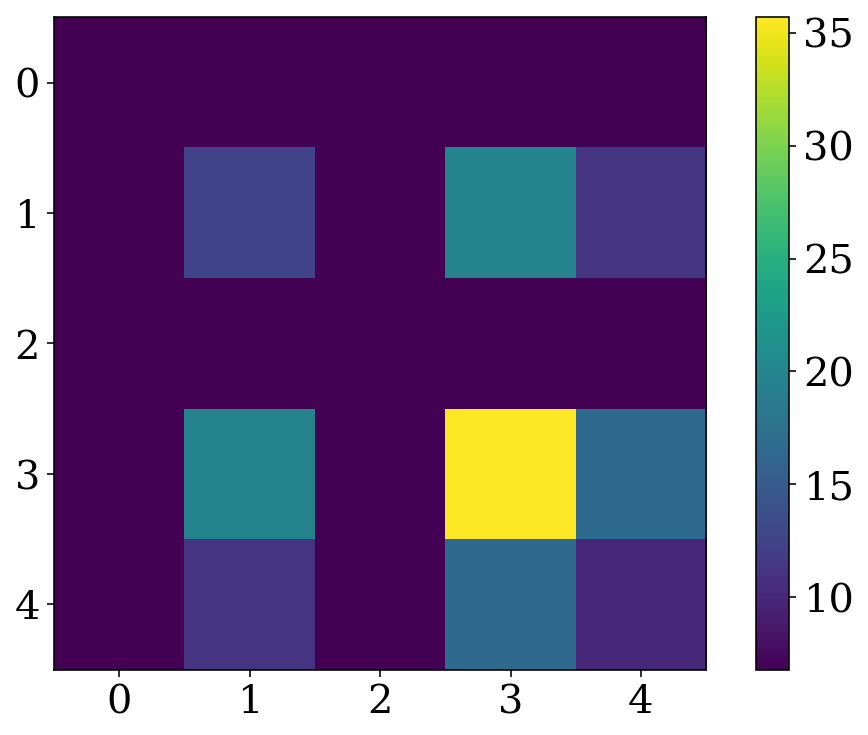

In [212]:
plt.imshow(second_order_linear)
plt.colorbar()

In [215]:
fit = np.zeros([N_mutation,N_mutation,N_mutation])

ref_fitness = RNA.fold(base_seq)[1]

for i in range(N_mutation):
#     seq = do_n_mutation(base_seq,mut_list,[i])
#     fitnesses[0,i] = RNA.fold(seq)[-1]
    for j in range(i,N_mutation):
        for k in range(j,N_mutation):
            seq = do_n_mutation(base_seq,mut_list,[i,j,k])
            fit[i,j,k] = RNA.fold(seq)[-1]    

In [216]:
idx = np.diag_indices(N_mutation)

fit[idx[0],idx[1],:]

array([[-6.80000019, -5.5999999 , -6.80000019, -3.        , -5.5       ],
       [ 0.        , -5.0999999 , -5.0999999 , -3.20000005, -3.79999995],
       [ 0.        ,  0.        , -6.80000019, -3.        , -5.5       ],
       [ 0.        ,  0.        ,  0.        , -3.        , -2.5       ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -5.5       ]])

In [217]:
fitnesses

array([[-6.80000019, -5.5999999 , -6.80000019, -3.        , -5.5       ],
       [ 0.        , -5.0999999 , -5.0999999 , -3.20000005, -3.79999995],
       [ 0.        ,  0.        , -6.80000019, -3.        , -5.5       ],
       [ 0.        ,  0.        ,  0.        , -3.        , -2.5       ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -5.5       ]])

## Thought

This whole slicing out high dimensional diagonals is dumb and too complicated. Just include the reference strain as the 0th element in mutation list for the fitness matrix.

In [233]:
fitnesses = np.zeros([N_mutation+1,N_mutation+1])

ref_fitness = RNA.fold(base_seq)[1]
mut_list_for_fitness = ['']+mut_list
for i in range(N_mutation+1):
    for j in range(i,N_mutation+1):
        seq = do_n_mutation(base_seq,mut_list_for_fitness,[i,j])
#         print(mut_list_for_fitness[i],mut_list_for_fitness[j], seq)
#         print(RNA.fold(seq)[-1] ,mut_list_for_fitness[i],mut_list_for_fitness[j])
        fitnesses[i,j] = RNA.fold(seq)[-1]    

here
here
here
here
here
here
here


In [235]:
mut_list

['C6U', 'C14G', 'U17C', 'U22G', 'G35C']

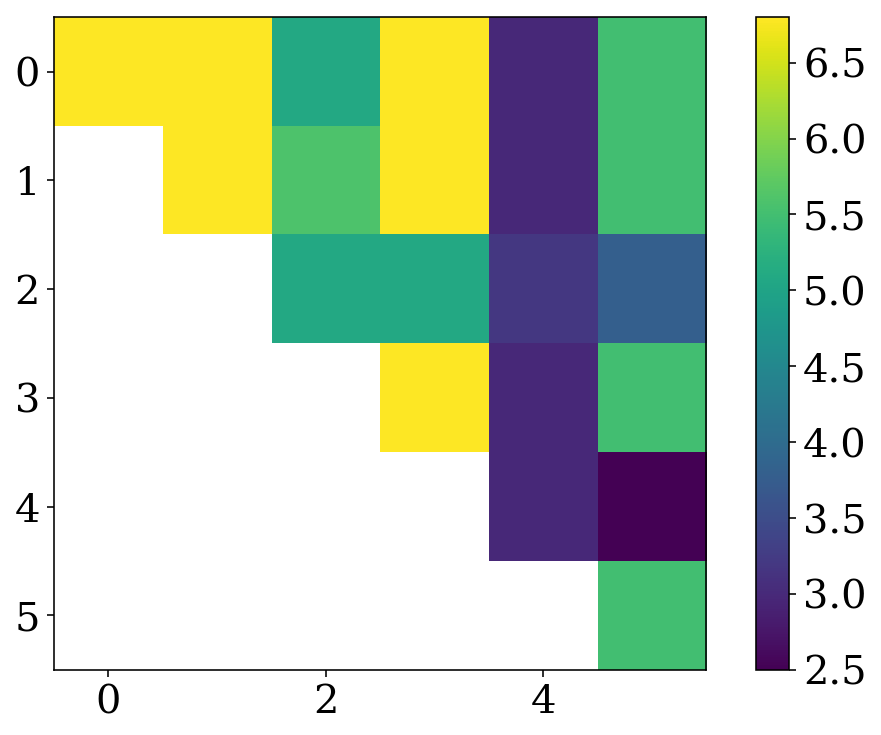

In [234]:
imshow_masked(-fitnesses)

-6.800000190734863

In [220]:
print(do_n_mutation(base_seq,mut_list_for_fitness,[3,3]))
print(do_n_mutation(base_seq,mut_list_for_fitness,[2,3]))

UCCCUCCGAUACGUCUACUCCCUGCACUCCUUCUAGUAUGCAGCCUGACU
UCCCUCCGAUACGUGUACUCCCUGCACUCCUUCUAGUAUGCAGCCUGACU


In [221]:
RNA.fold(do_n_mutation(base_seq,mut_list_for_fitness,[1,4]))[-1]

-3.0

In [222]:
base_seq = 'UCCCUCCGAUACGUCUAUUCCCUGCACUCCUUCUAGUAUGCAGCCUGACU'
good_mutations = ['U0A', 'C2A', 'C21A', 'U22A', 'C29G']

In [223]:
for i in range(len(good_mutations)):
    for j in range(i,len(good_mutations)):
        print(RNA.fold(do_n_mutation(base_seq,good_mutations,[i,j]))[-1])
    

-6.800000190734863
-6.800000190734863
-5.099999904632568
-2.299999952316284
-8.100000381469727
-6.800000190734863
-5.099999904632568
-2.299999952316284
-8.100000381469727
-5.099999904632568
-2.200000047683716
-6.099999904632568
-2.299999952316284
-3.5
-8.100000381469727


In [252]:
ref = .89
fit = np.array([[.89,.29,.78],[.29, 0,1.31],[.78,1.31,0]])

N = 3
diag = np.diag(fit)
second_order = np.zeros([N,N])
for bkgd in range(N):
    for mut in range(N):
        second_order[bkgd,mut] = (fit[bkgd,mut]-fit[0,bkgd]) - (fit[0,mut]-ref)
# imshow_masked(second_order)
fit[np.diag_indices_from(fit)] = fit[0]
print(fit)

second_order

[[ 0.89  0.29  0.78]
 [ 0.29  0.29  1.31]
 [ 0.78  1.31  0.78]]


array([[ 0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.31,  1.13],
       [ 0.  ,  1.13, -0.67]])

In [253]:
arr = fit - fit[0][None,:] - fit[0][:,None] +ref
eps = 1e-9
arr[arr <eps] = 0
arr

array([[ 0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.6 ,  1.13],
       [ 0.  ,  1.13,  0.11]])

## now the diagonal in this case at least is the first order

maybe as i continue to higher orer the diagonal will always be the prior order?

+ maybe can go back to using the diag to get teh fitnesses.